In [ ]:
%pip install scikit-plot

In [ ]:
from __future__ import print_function
import os
import re
import tqdm
import string
import pandas as pd
import numpy as np
import keras
from nltk.corpus import stopwords
import gensim
from gensim.models.doc2vec import LabeledSentence
from gensim import utils
from gensim.models import Doc2Vec
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score,classification_report
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding, Input, RepeatVector,Flatten,Bidirectional
from keras.optimizers import SGD,Adam,RMSprop
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import scikitplot.plotters as skplt

In [ ]:
os.chdir('/content/drive/MyDrive/NLP_task/')

In [ ]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [ ]:
df_train['Abstract'] = df_train['Abstract'].apply(str)
df_test['Abstract'] = df_test['Abstract'].apply(str)

### Taking into account sequential nature of text using a simple LSTM

In [ ]:
num_words=2000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(df_train['Abstract'].values)

In [ ]:
X = tokenizer.texts_to_sequences(df_train['Abstract'].values)
X = pad_sequences(X, maxlen=2000)

In [ ]:
embed_dim = 128
lstm_out = 196

# Model saving callback
ckpt_callback = ModelCheckpoint('keras_model', 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')

model = Sequential()
model.add(Embedding(num_words, embed_dim, input_length = X.shape[1]))
model.add(LSTM(lstm_out, recurrent_dropout=0.2, dropout=0.2))
model.add(Dense(4,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['categorical_crossentropy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2000, 128)         256000    
_________________________________________________________________
lstm (LSTM)                  (None, 196)               254800    
_________________________________________________________________
dense (Dense)                (None, 4)                 788       
Total params: 511,588
Trainable params: 511,588
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
Y = pd.get_dummies(df_train['Label']).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, stratify=Y)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(8524, 2000) (8524, 4)
(2131, 2000) (2131, 4)


In [ ]:
batch_size = 32
model.fit(X_train, Y_train, epochs=8, batch_size=batch_size, validation_split=0.2, callbacks=[ckpt_callback])

Epoch 1/8
214/214 [==============================] - 1635s 8s/step - loss: 1.1847 - categorical_crossentropy: 1.1847 - val_loss: 1.1452 - val_categorical_crossentropy: 1.1452

Epoch 00001: val_loss improved from inf to 1.14522, saving model to keras_model
INFO:tensorflow:Assets written to: keras_model/assets
Epoch 2/8
214/214 [==============================] - 1633s 8s/step - loss: 0.7862 - categorical_crossentropy: 0.7862 - val_loss: 1.8775 - val_categorical_crossentropy: 1.8775

Epoch 00002: val_loss did not improve from 1.14522
Epoch 3/8
214/214 [==============================] - 1627s 8s/step - loss: 1.1239 - categorical_crossentropy: 1.1239 - val_loss: 1.2525 - val_categorical_crossentropy: 1.2525

Epoch 00003: val_loss did not improve from 1.14522
Epoch 4/8
214/214 [==============================] - 1642s 8s/step - loss: 0.6675 - categorical_crossentropy: 0.6675 - val_loss: 0.5201 - val_categorical_crossentropy: 0.5201

Epoch 00004: val_loss improved from 1.14522 to 0.52010, savi

Log loss: 0.39012164175781644
Accuracy: 0.8723603941811356
              precision    recall  f1-score   support

           1       0.84      0.91      0.87       644
           2       0.92      0.99      0.95       484
           3       0.93      0.90      0.91       752
           4       0.65      0.49      0.56       251

    accuracy                           0.87      2131
   macro avg       0.83      0.82      0.82      2131
weighted avg       0.87      0.87      0.87      2131



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


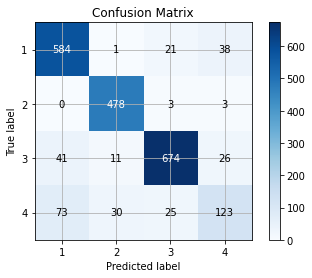

In [ ]:
model = load_model('keras_model')
probas = model.predict(X_test)
pred_indices = np.argmax(probas, axis=1)
classes = np.array(range(1, 5))
preds = classes[pred_indices]
print('Log loss: {}'.format(log_loss(classes[np.argmax(Y_test, axis=1)], probas)))
print('Accuracy: {}'.format(accuracy_score(classes[np.argmax(Y_test, axis=1)], preds)))
print(classification_report(classes[np.argmax(Y_test, axis=1)], preds, labels=classes))
skplt.plot_confusion_matrix(classes[np.argmax(Y_test, axis=1)], preds)

On test data set

In [ ]:
x_train = tokenizer.texts_to_sequences(df_test['Abstract'].values)
x_train = pad_sequences(x_train, maxlen=2000)
y_train = pd.get_dummies(df_test['Label']).values

Log loss: 0.44376803292393996
Accuracy: 0.8552660389752573
              precision    recall  f1-score   support

           1       0.79      0.91      0.85      1379
           2       0.91      0.98      0.94      1038
           3       0.93      0.86      0.90      1612
           4       0.66      0.45      0.53       538

    accuracy                           0.86      4567
   macro avg       0.82      0.80      0.80      4567
weighted avg       0.85      0.86      0.85      4567



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


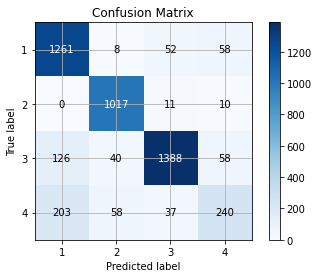

In [ ]:
model = load_model('keras_model')
probas = model.predict(x_train)
pred_indices = np.argmax(probas, axis=1)
classes = np.array(range(1, 5))
preds = classes[pred_indices]
print('Log loss: {}'.format(log_loss(classes[np.argmax(y_train, axis=1)], probas)))
print('Accuracy: {}'.format(accuracy_score(classes[np.argmax(y_train, axis=1)], preds)))
print(classification_report(classes[np.argmax(y_train, axis=1)], preds, labels=classes))
skplt.plot_confusion_matrix(classes[np.argmax(y_train, axis=1)], preds)

# Using pretrained embeddings for deep learning model

## Using word2vec trained embeddings

In [ ]:
X = np.load('trainglove.npy')
x_test = np.load('testglove.npy')
embedding_matrix = np.load('glovembed.npy')

In [ ]:
y_test = pd.get_dummies(df_test['Label']).values

In [ ]:
embedding_matrix.shape

(58097, 300)

In [ ]:
max_length = 300
lstm_out = 196
num_words = 58097

# Model saving callback
ckpt_callback2 = ModelCheckpoint('glove_model', 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')

gmodel = Sequential()
gmodel.add(Embedding(num_words, max_length, weights=[embedding_matrix] ,input_length = max_length,trainable=False))
gmodel.add(Bidirectional(LSTM(lstm_out,return_sequences=True)))
gmodel.add(Dropout(0.2))
gmodel.add(Bidirectional(LSTM(lstm_out)))
gmodel.add(Dropout(0.2))
gmodel.add(Dense(4,activation='softmax'))
gmodel.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['categorical_crossentropy'])
print(gmodel.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 300)          17429100  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 300, 392)          779296    
_________________________________________________________________
dropout_2 (Dropout)          (None, 300, 392)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 392)               923552    
_________________________________________________________________
dropout_3 (Dropout)          (None, 392)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1572      
Total params: 19,133,520
Trainable params: 1,704,420
Non-trainable params: 17,429,100
__________________________________

In [ ]:
batch_size = 32
gmodel.fit(X, Y, epochs=8, batch_size=batch_size, validation_split=0.2, callbacks=[ckpt_callback2])

Epoch 1/8
267/267 [==============================] - 30s 94ms/step - loss: 0.5900 - categorical_crossentropy: 0.5900 - val_loss: 0.3954 - val_categorical_crossentropy: 0.3954

Epoch 00001: val_loss improved from inf to 0.39537, saving model to glove_model


INFO:tensorflow:Assets written to: glove_model/assets


INFO:tensorflow:Assets written to: glove_model/assets


Epoch 2/8
267/267 [==============================] - 25s 92ms/step - loss: 0.3053 - categorical_crossentropy: 0.3053 - val_loss: 0.3272 - val_categorical_crossentropy: 0.3272

Epoch 00002: val_loss improved from 0.39537 to 0.32721, saving model to glove_model


INFO:tensorflow:Assets written to: glove_model/assets


INFO:tensorflow:Assets written to: glove_model/assets


Epoch 3/8
267/267 [==============================] - 25s 94ms/step - loss: 0.2369 - categorical_crossentropy: 0.2369 - val_loss: 0.2270 - val_categorical_crossentropy: 0.2270

Epoch 00003: val_loss improved from 0.32721 to 0.22700, saving model to glove_model


INFO:tensorflow:Assets written to: glove_model/assets


INFO:tensorflow:Assets written to: glove_model/assets


Epoch 4/8
267/267 [==============================] - 25s 92ms/step - loss: 0.1958 - categorical_crossentropy: 0.1958 - val_loss: 0.2252 - val_categorical_crossentropy: 0.2252

Epoch 00004: val_loss improved from 0.22700 to 0.22516, saving model to glove_model


INFO:tensorflow:Assets written to: glove_model/assets


INFO:tensorflow:Assets written to: glove_model/assets


Epoch 5/8
267/267 [==============================] - 25s 92ms/step - loss: 0.1737 - categorical_crossentropy: 0.1737 - val_loss: 0.2435 - val_categorical_crossentropy: 0.2435

Epoch 00005: val_loss did not improve from 0.22516
Epoch 6/8
267/267 [==============================] - 25s 93ms/step - loss: 0.1457 - categorical_crossentropy: 0.1457 - val_loss: 0.2164 - val_categorical_crossentropy: 0.2164

Epoch 00006: val_loss improved from 0.22516 to 0.21645, saving model to glove_model


INFO:tensorflow:Assets written to: glove_model/assets


INFO:tensorflow:Assets written to: glove_model/assets


Epoch 7/8
267/267 [==============================] - 25s 92ms/step - loss: 0.1292 - categorical_crossentropy: 0.1292 - val_loss: 0.2262 - val_categorical_crossentropy: 0.2262

Epoch 00007: val_loss did not improve from 0.21645
Epoch 8/8
267/267 [==============================] - 25s 94ms/step - loss: 0.1025 - categorical_crossentropy: 0.1025 - val_loss: 0.2240 - val_categorical_crossentropy: 0.2240

Epoch 00008: val_loss did not improve from 0.21645


Log loss: 0.23414311362559376
Accuracy: 0.9198598642434859
              precision    recall  f1-score   support

           1       0.91      0.90      0.90      1379
           2       0.96      0.97      0.97      1038
           3       0.95      0.97      0.96      1612
           4       0.77      0.71      0.74       538

    accuracy                           0.92      4567
   macro avg       0.90      0.89      0.89      4567
weighted avg       0.92      0.92      0.92      4567



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


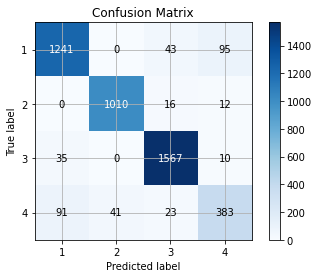

In [ ]:
probas = gmodel.predict(x_test)
pred_indices = np.argmax(probas, axis=1)
classes = np.array(range(1, 5))
preds = classes[pred_indices]
print('Log loss: {}'.format(log_loss(classes[np.argmax(y_test, axis=1)], probas)))
print('Accuracy: {}'.format(accuracy_score(classes[np.argmax(y_test, axis=1)], preds)))
print(classification_report(classes[np.argmax(y_test, axis=1)], preds, labels=classes))
skplt.plot_confusion_matrix(classes[np.argmax(y_test, axis=1)], preds)

## Using doc2vec trained embeddings 

In [ ]:
train_arr = np.load('traindoc2vec.npy')
test_arr = np.load('testdoc2vec.npy')
d2vmodel = gensim.models.Word2Vec.load('d2vmodel')

In [ ]:
print(train_arr.shape,test_arr.shape)

(10655, 300) (4567, 300)


In [ ]:
y = pd.get_dummies(df_train['Label']).values

In [ ]:
y_test = pd.get_dummies(df_test['Label']).values

In [ ]:
def base_model(input_dim=300):
    model = Sequential()
    model.add(Dense(256,input_dim=input_dim,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(80, activation='relu'))
    model.add(Dense(4, activation="softmax"))
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)  
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy','categorical_crossentropy'])
    return model

ckpt_callback_1 = ModelCheckpoint('keras_model_d2v', 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')

In [ ]:
model_d2v = base_model()
model_d2v.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               77056     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 80)                20560     
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 324       
Total params: 163,732
Trainable params: 163,732
Non-trainable params: 0
________________________________________________

In [ ]:
estimator=model_d2v.fit(train_arr, y, validation_split=0.2, epochs=20, batch_size=32,callbacks=[ckpt_callback_1])

Epoch 1/20
267/267 [==============================] - 1s 3ms/step - loss: 0.5989 - accuracy: 0.7672 - categorical_crossentropy: 0.5989 - val_loss: 0.5429 - val_accuracy: 0.7949 - val_categorical_crossentropy: 0.5429

Epoch 00001: val_loss improved from 0.55236 to 0.54294, saving model to keras_model_d2v
INFO:tensorflow:Assets written to: keras_model_d2v/assets
Epoch 2/20
267/267 [==============================] - 1s 3ms/step - loss: 0.5891 - accuracy: 0.7744 - categorical_crossentropy: 0.5891 - val_loss: 0.5304 - val_accuracy: 0.7912 - val_categorical_crossentropy: 0.5304

Epoch 00002: val_loss improved from 0.54294 to 0.53038, saving model to keras_model_d2v
INFO:tensorflow:Assets written to: keras_model_d2v/assets
Epoch 3/20
267/267 [==============================] - 1s 3ms/step - loss: 0.5792 - accuracy: 0.7782 - categorical_crossentropy: 0.5792 - val_loss: 0.5083 - val_accuracy: 0.8038 - val_categorical_crossentropy: 0.5083

Epoch 00003: val_loss improved from 0.53038 to 0.50832, s

On test dataset

Log loss: 0.49827545878656987
Accuracy: 0.8031530545215678
              precision    recall  f1-score   support

           1       0.74      0.90      0.81      1379
           2       0.89      0.89      0.89      1038
           3       0.83      0.80      0.82      1612
           4       0.68      0.38      0.49       538

    accuracy                           0.80      4567
   macro avg       0.79      0.74      0.75      4567
weighted avg       0.80      0.80      0.79      4567



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


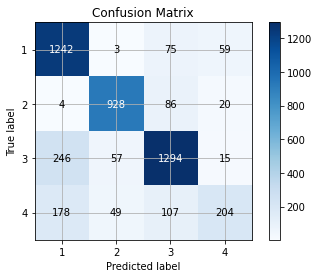

In [ ]:
probas = model_d2v.predict(test_arr)
pred_indices = np.argmax(probas, axis=1)
classes = np.array(range(1, 5))
preds = classes[pred_indices]
print('Log loss: {}'.format(log_loss(classes[np.argmax(y_test, axis=1)], probas)))
print('Accuracy: {}'.format(accuracy_score(classes[np.argmax(y_test, axis=1)], preds)))
print(classification_report(classes[np.argmax(y_test, axis=1)], preds, labels=classes))
skplt.plot_confusion_matrix(classes[np.argmax(y_test, axis=1)], preds)

In [ ]:
def lstm_model(input_dim=300):
    lstm_out = 350
    model = Sequential()
    model.add(LSTM(lstm_out,return_sequences=True, dropout=0.6, input_shape=(1, input_dim)))
    model.add(Dropout(0.8))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(10, activation='relu'))
#   model.add(Dropout(0.08))
#   model.add(Flatten())
    model.add(Dense(4, activation="softmax"))
#   sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)     
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
    return model

ckpt_callback_2 = ModelCheckpoint('keras_model_d2v_new', 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')

In [ ]:
train_arr_lstm = np.reshape(train_arr,(train_arr.shape[0],1,train_arr.shape[1]))
test_arr_lstm = np.reshape(test_arr,(test_arr.shape[0],1,test_arr.shape[1]))

In [ ]:
print(train_arr_lstm.shape,test_arr_lstm.shape)

(10655, 1, 300) (4567, 1, 300)


In [ ]:
d2v_model_lstm = lstm_model()
d2v_model_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 350)            911400    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 350)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 1, 10)             3510      
_________________________________________________________________
dense_12 (Dense)             (None, 1, 10)             110       
_________________________________________________________________
dense_13 (Dense)             (None, 1, 4)              44        
Total params: 915,064
Trainable params: 915,064
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_lstm = np.reshape(y,(y.shape[0],1,y.shape[1]))
y_test

In [ ]:
estimator_new = d2v_model_lstm.fit(train_arr_lstm, y_lstm, validation_split=0.2, epochs=20, batch_size=32,callbacks=[ckpt_callback_2])

Epoch 1/20
267/267 [==============================] - 3s 11ms/step - loss: 0.6621 - accuracy: 0.7459 - val_loss: 0.5757 - val_accuracy: 0.7724

Epoch 00001: val_loss improved from 0.58950 to 0.57565, saving model to keras_model_d2v_new


INFO:tensorflow:Assets written to: keras_model_d2v_new/assets


INFO:tensorflow:Assets written to: keras_model_d2v_new/assets


Epoch 2/20
267/267 [==============================] - 3s 11ms/step - loss: 0.6539 - accuracy: 0.7464 - val_loss: 0.5738 - val_accuracy: 0.7757

Epoch 00002: val_loss improved from 0.57565 to 0.57382, saving model to keras_model_d2v_new


INFO:tensorflow:Assets written to: keras_model_d2v_new/assets


INFO:tensorflow:Assets written to: keras_model_d2v_new/assets


Epoch 3/20
267/267 [==============================] - 3s 13ms/step - loss: 0.6487 - accuracy: 0.7443 - val_loss: 0.5619 - val_accuracy: 0.7738

Epoch 00003: val_loss improved from 0.57382 to 0.56195, saving model to keras_model_d2v_new


INFO:tensorflow:Assets written to: keras_model_d2v_new/assets


INFO:tensorflow:Assets written to: keras_model_d2v_new/assets


Epoch 4/20
267/267 [==============================] - 3s 11ms/step - loss: 0.6443 - accuracy: 0.7484 - val_loss: 0.5678 - val_accuracy: 0.7785

Epoch 00004: val_loss did not improve from 0.56195
Epoch 5/20
267/267 [==============================] - 3s 11ms/step - loss: 0.6370 - accuracy: 0.7522 - val_loss: 0.5588 - val_accuracy: 0.7743

Epoch 00005: val_loss improved from 0.56195 to 0.55882, saving model to keras_model_d2v_new


INFO:tensorflow:Assets written to: keras_model_d2v_new/assets


INFO:tensorflow:Assets written to: keras_model_d2v_new/assets


Epoch 6/20
267/267 [==============================] - 3s 11ms/step - loss: 0.6289 - accuracy: 0.7526 - val_loss: 0.5602 - val_accuracy: 0.7790

Epoch 00006: val_loss did not improve from 0.55882
Epoch 7/20
267/267 [==============================] - 3s 11ms/step - loss: 0.6338 - accuracy: 0.7516 - val_loss: 0.5473 - val_accuracy: 0.7776

Epoch 00007: val_loss improved from 0.55882 to 0.54730, saving model to keras_model_d2v_new


INFO:tensorflow:Assets written to: keras_model_d2v_new/assets


INFO:tensorflow:Assets written to: keras_model_d2v_new/assets


Epoch 8/20
267/267 [==============================] - 3s 11ms/step - loss: 0.6304 - accuracy: 0.7528 - val_loss: 0.5491 - val_accuracy: 0.7804

Epoch 00008: val_loss did not improve from 0.54730
Epoch 9/20
267/267 [==============================] - 3s 11ms/step - loss: 0.6226 - accuracy: 0.7611 - val_loss: 0.5508 - val_accuracy: 0.7860

Epoch 00009: val_loss did not improve from 0.54730
Epoch 10/20
267/267 [==============================] - 3s 11ms/step - loss: 0.6228 - accuracy: 0.7535 - val_loss: 0.5468 - val_accuracy: 0.7823

Epoch 00010: val_loss improved from 0.54730 to 0.54679, saving model to keras_model_d2v_new


INFO:tensorflow:Assets written to: keras_model_d2v_new/assets


INFO:tensorflow:Assets written to: keras_model_d2v_new/assets


Epoch 11/20
267/267 [==============================] - 3s 11ms/step - loss: 0.6291 - accuracy: 0.7553 - val_loss: 0.5485 - val_accuracy: 0.7870

Epoch 00011: val_loss did not improve from 0.54679
Epoch 12/20
267/267 [==============================] - 3s 11ms/step - loss: 0.6238 - accuracy: 0.7586 - val_loss: 0.5419 - val_accuracy: 0.7823

Epoch 00012: val_loss improved from 0.54679 to 0.54189, saving model to keras_model_d2v_new


INFO:tensorflow:Assets written to: keras_model_d2v_new/assets


INFO:tensorflow:Assets written to: keras_model_d2v_new/assets


Epoch 13/20
267/267 [==============================] - 3s 11ms/step - loss: 0.6249 - accuracy: 0.7580 - val_loss: 0.5428 - val_accuracy: 0.7870

Epoch 00013: val_loss did not improve from 0.54189
Epoch 14/20
267/267 [==============================] - 3s 11ms/step - loss: 0.6207 - accuracy: 0.7569 - val_loss: 0.5440 - val_accuracy: 0.7823

Epoch 00014: val_loss did not improve from 0.54189
Epoch 15/20
267/267 [==============================] - 3s 11ms/step - loss: 0.6120 - accuracy: 0.7586 - val_loss: 0.5435 - val_accuracy: 0.7865

Epoch 00015: val_loss did not improve from 0.54189
Epoch 16/20
267/267 [==============================] - 3s 11ms/step - loss: 0.6158 - accuracy: 0.7572 - val_loss: 0.5358 - val_accuracy: 0.7874

Epoch 00016: val_loss improved from 0.54189 to 0.53581, saving model to keras_model_d2v_new


INFO:tensorflow:Assets written to: keras_model_d2v_new/assets


INFO:tensorflow:Assets written to: keras_model_d2v_new/assets


Epoch 17/20
267/267 [==============================] - 3s 11ms/step - loss: 0.6167 - accuracy: 0.7582 - val_loss: 0.5352 - val_accuracy: 0.7912

Epoch 00017: val_loss improved from 0.53581 to 0.53520, saving model to keras_model_d2v_new


INFO:tensorflow:Assets written to: keras_model_d2v_new/assets


INFO:tensorflow:Assets written to: keras_model_d2v_new/assets


Epoch 18/20
267/267 [==============================] - 3s 11ms/step - loss: 0.6128 - accuracy: 0.7601 - val_loss: 0.5344 - val_accuracy: 0.7884

Epoch 00018: val_loss improved from 0.53520 to 0.53437, saving model to keras_model_d2v_new


INFO:tensorflow:Assets written to: keras_model_d2v_new/assets


INFO:tensorflow:Assets written to: keras_model_d2v_new/assets


Epoch 19/20
267/267 [==============================] - 3s 11ms/step - loss: 0.6113 - accuracy: 0.7590 - val_loss: 0.5323 - val_accuracy: 0.7870

Epoch 00019: val_loss improved from 0.53437 to 0.53229, saving model to keras_model_d2v_new


INFO:tensorflow:Assets written to: keras_model_d2v_new/assets


INFO:tensorflow:Assets written to: keras_model_d2v_new/assets


Epoch 20/20
267/267 [==============================] - 3s 11ms/step - loss: 0.6083 - accuracy: 0.7631 - val_loss: 0.5364 - val_accuracy: 0.7879

Epoch 00020: val_loss did not improve from 0.53229


On test data

Log loss: 0.5560077807738087
Accuracy: 0.7740310926209766
              precision    recall  f1-score   support

           1       0.73      0.90      0.80      1379
           2       0.85      0.92      0.88      1038
           3       0.81      0.74      0.77      1612
           4       0.55      0.28      0.37       538

    accuracy                           0.77      4567
   macro avg       0.73      0.71      0.71      4567
weighted avg       0.76      0.77      0.76      4567



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


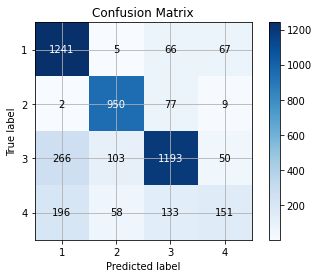

In [ ]:
probas = d2v_model_lstm.predict(test_arr_lstm)
probas = np.reshape(probas,(probas.shape[0],probas.shape[2]))
pred_indices = np.argmax(probas, axis=1)
classes = np.array(range(1, 5))
preds = classes[pred_indices]
print('Log loss: {}'.format(log_loss(classes[np.argmax(y_test, axis=1)], probas)))
print('Accuracy: {}'.format(accuracy_score(classes[np.argmax(y_test, axis=1)], preds)))
print(classification_report(classes[np.argmax(y_test, axis=1)], preds, labels=classes))
skplt.plot_confusion_matrix(classes[np.argmax(y_test, axis=1)], preds)